# Regresión Lineal

En estadśitica, la regresión lineal es un modelo matemático usado para aproximar la relación de dependencia entre una variable dependiente $Y$, las variables independeintes $X_i$ y un termino aleatorio $C$. __[REF](https://es.wikipedia.org/wiki/Regresi%C3%B3n_lineal)__

\begin{align}
Y_t = a_0 X_0 + a_1 X_1 + a_2 X_2 + ... + a_n X_n + C
\end{align}

En otras palabras, lo que se busca es obtener una función que modele el comportamiento de los datos que tenemos. Se busca una aproximación.


En la imágen siguiente se puede apreciar un ejemplo. Se tienen $N$ cantidad de puntos en un plano cartesiano y se desea obtener una función que modele de manera optima el comportamiento de dichos puntos. Para este caso, con una recta es suficiente.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Linear_regression.svg/1200px-Linear_regression.svg.png" width="800">

# Ejemplo

Supongase que tenemos una vace de datos, como la que se muestra más abajo, y queremos obtener un modelo del comportamiento de estos puntos para poder predecir los valores de las $y$s de los puntos intermedios entre las x conocidas.

| X | Y  |
|---|----|
| 0 | 0  |
| 2 | 4  |
| 4 | 8  |
| 6 | 12 |
| . | .  |
| . | .  |

Con los pocos puntos mostrados en la tabla, podemos deducir que la su comportamiento es lineal y que la función que mejor se aproxima a los datos es $f(x) = 2x$. Sin embargo, asumamos que no sabemos que función es. De lo unico que estamos seguros es de que es lineal, por lo que una neurona será suficiente para este trabajo. En caso de que nos equivocaramos y notaramos que nuestro modelo no logra aproximar el comportamiento, bastaría con agregar más neuronas a nuestra arquitectura.

Nuestro modelo queda expresado en la siguiente función, donde $W \approx 2$ y $b \approx 0$ (que por ahora eso nosotros no lo sabemos).

\begin{align}
Y_{pred} = WX + b
\end{align}

In [1]:
# Importamos las librerias necesarias
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
#%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Importamos algunas funciones auxiliares
from regresion_lineal import Data, print_all_tensors,obtener_wb

/home/hectorsab/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Datos de entrenamiento y prueba

Como se discutió anteriormente, para trabajar con redes neuronales artificiales, dependemos de tener una base de datos que refleje el comportamiento que deseamos modelar.

Una buena práctica es dividir nuestra base de datos en tres: entrenamiento (**training set**), validación (**validation set**), prueba (**test set**).

La manera en que suele hacerse esto-no es obligatorio-es, del total de ejemplos en tu base de datos un 80% será para el entrenamiento y el restante para las pruebas. Una vez definidos estos dos conjuntos, volvemos a separar el conjunto de entrenamiento en 80-20, para redefinir el conjunto de entrenamiento y crear el de validación respectivamente.

¿Para que hacer esto? Al final del día se tiene que corroborar que tan bien funciona nuestro modelo, una forma de hacer esto es medir su desempeño con información que nunca antes vió y para la cual el modelo no fue ajustado para obtener un máximo desempeño. Así pues, el conjunto de entrenamiento es utilizado para entrenar nuestra red, y el conjunto de validación nos sirve para ver la evolución del "aprendizaje" e intentar minimizar el total de errores sobre esta base de datos.

Dado que este es un ejemplo sencillo, nos olvidaremos del conjunto de validación y solo utilizaremos el de entrenamiento y prueba, ambos con una cantidad similar de ejemplos.

In [2]:
# Datos de entrenamiento
X = np.array([0,2,4,6,8,10]).T # Valores de entrada
Y = 2*X # Valores esperados

# Datos de prueba
Xt = np.array([1,3,5,7,9]).T # Valores de entrada
Yt = 2*Xt # Valores esperados

# Definicion de las bases de datos para un manejo más sencillo durante el 
# entrenamiento
train = Data(x=X,y=Y)
test = Data(x=Xt,y=Yt)

print('X:  {}'.format(X.T))
print('Y:  {}'.format(Y.T))
print('Xt: {}'.format(Xt.T))
print('Yt: {}'.format(Yt.T))

X:  [ 0  2  4  6  8 10]
Y:  [ 0  4  8 12 16 20]
Xt: [1 3 5 7 9]
Yt: [ 2  6 10 14 18]


In [3]:
# Si se desea obtener un sub conjunto de tamaño bs
# se utiliza el siguiente metodo.
print(train.next_batch(bs=1))

(array([[0]]), array([[0]]))


# Definición del Modelo

Conforme al funcionamiento de los grafos en TensorFlow, creamos las variables por donde se introducirá la información. Cuando utilizamos **None** en la definición del tamaño del placeholder, indica que acepta un número dinámico de elementos de entrada.

In [4]:
# Definimos las entradas de informacion al grafo
inp_x = tf.placeholder(tf.float32,shape=[None,1],name='inp_x')
gt_y = tf.placeholder(tf.float32,shape=[None,1],name='gt_y')

print('inp_x: {}'.format(inp_x))
print('gt_y: {}'.format(gt_y))

inp_x: Tensor("inp_x:0", shape=(?, 1), dtype=float32)
gt_y: Tensor("gt_y:0", shape=(?, 1), dtype=float32)


Como se comentó anteriormente, decidimos que una neurona será más que suficiente para este ejercicio. Definimos la arquitectura a continuación.

In [5]:
# Definimos la arquitectura
layer1 = tf.layers.dense(inputs=inp_x,units=1,name='layer1') # Neurona con una salida (units=1)
y_pred = tf.identity(layer1,name='y_pred') # Predicciones. Copia de la capa layer1
print(y_pred)

Tensor("y_pred:0", shape=(?, 1), dtype=float32)


# Función de Perdida

Cuando utilizamos Deep Learning, para desarrollar un buen modelo hace falta el poder determinar el desempeño con respecto a una base de datos. La función de perdida nos permite calcular el error de nuestra arquitectura a partir de las predicciones con respecto a las reales.

Para este ejemplo utilizaremos el **MSE** (Mean Square Error, o Error Cuadrático Promedio en español). Donde el error por cada ejemplo entrenado es:

\begin{align}
loss_i = (Y_i - Ŷ_i)^2
\end{align}

Y donde la función de perdida final queda expresada:

\begin{align}
L = \frac{1}{n} \sum_{i=0}^{n} loss_i
\end{align}

In [6]:
# Definimos nuestra función de perdida
loss = tf.pow(gt_y - y_pred,2.,name='loss')
cost = tf.reduce_mean(loss,name='cost')

print('loss: {}'.format(loss))
print('cost: {}'.format(cost))

loss: Tensor("loss:0", shape=(?, 1), dtype=float32)
cost: Tensor("cost:0", shape=(), dtype=float32)


# Back Propagation

Una vez que tenemos la arquitectura y la función de perdida definidas, el siguiente paso es seleccionar el metodo de optimización que se desea utilizar. Para este ejemplo se utilizará **Adam Optimizer** juto con una taza de aprendizaje de 0.0001.

In [7]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

Conforme al funcionamiento de TensorFlow, creamos la sesión donde se ejecutará todo nuestro grafo.

In [8]:
sess = tf.Session()

Se inicializan los pesos aleatoreamente.

In [9]:
sess.run(tf.global_variables_initializer())

Se crea una función auxiliar que permitirá obtener los valores $Ŷ$ dados $X$.

In [10]:
def predict(x):
    # Predice los valores de y correspondientes a x.
    # Args:
    #    x (np.array): Valores X a los que se desea predecir Y.
    #        Su forma debe de ser [None,1]
    # Returns
    #    pred (np.array): Regresa los valores Y predichos.
    #        Su forma es de [None,1]
    fd = {inp_x:x}
    pred = sess.run(y_pred,feed_dict=fd)
    return(pred)

Se crea una función auxiliar para entrenar a la red.

In [11]:
def train_nn(iters,train_set,bs=1):
    # Entrena a la red neuronal
    # Args:
    #    iters (int): Numero de iteraciones
    #    train_set (Data): Base de datos con la que se entrenara
    #    bs (int): Tamaño del sub set con el que se entrenara cada iteracion
    pbar = tqdm(range(iters))
    for i in pbar:
        next_bs = train_set.next_batch(bs)
        
        fd = {inp_x:next_bs[0],gt_y:next_bs[1]}
        cst,_ = sess.run([cost,optimizer],feed_dict=fd)
        pbar.set_description('Cost: {:.4f}'.format(float(cst)))

In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

def train_nn_viz(iters,train_set,bs=1):
    # Entrena a la red neuronal y muestra el la evolución de los resultados graficamente
    # Args:
    #    iters (int): Numero de iteraciones
    #    train_set (Data): Base de datos con la que se entrenara
    #    bs (int): Tamaño del sub set con el que se entrenara cada iteracion    
    
    # Creamos una figura donde dibujar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.ion()
    
    # Indicamos los limites de nuestros ejes
    plt.xlim(-1, 10)
    plt.ylim(-1, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Mostramos la figura
    fig.show()
    fig.canvas.draw()
    
    pbar = tqdm(range(iters))
    for i in pbar:
        next_bs = train_set.next_batch(bs)
        fd = {inp_x:next_bs[0],gt_y:next_bs[1]}
        cst,_ = sess.run([cost,optimizer],feed_dict=fd)
        
        pbar.set_description('Cost: {:.4f}'.format(float(cst)))
        if i%10==0:
            # Limpiamos el contenido de la figura
            ax.clear()
            # Obtenemos los valores de w y b
            w,b = obtener_wb(sess=sess)
            # Evaluamos nuestro modelo
            x1 = -1; y1 = w[0,0]*(x1) + b[0]
            x2 = 10; y2 = w[0,0]*(x2) + b[0]
            # Dibujamos la linea
            ax.plot([x1,x2],[y1,y2])
            fig.canvas.draw()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Obtenemos un subconjunto de ejemplos de la base de datos de prueba para visualizar las predicciones que tiene antes y despues de ser entrenada.

In [13]:
test_data = test.next_batch(5)

Predecimos los valores de $Ŷ$ dado $X$.

In [ ]:
pred = predict(test_data[0])
print('GTx: {}\nGTy: {}\nPRy: {}'.format(test_data[0].T,test_data[1].T,pred.T))

Entrenamos nuestro modelo utilizando la base de datos "train".

<IPython.core.display.Javascript object>


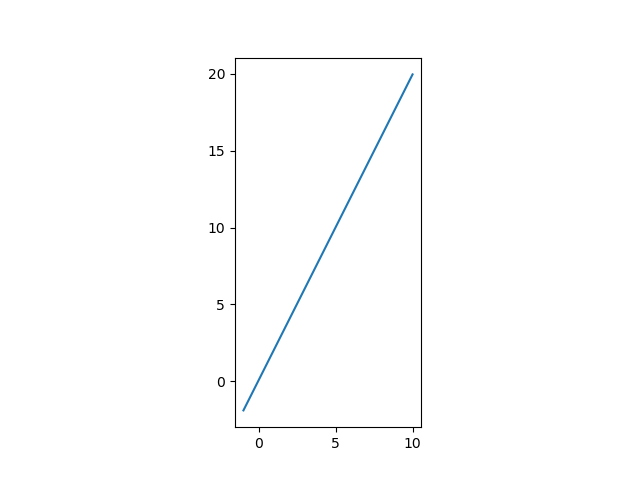

Cost: 0.0006: 100%|██████████| 3000/3000 [00:23<00:00, 125.43it/s]


In [26]:
train_nn_viz(iters=3000,train_set=train,bs=3)

Volvemos a predecir $Ŷ$ dado $X$ para ver la evolución de los resultados.

In [ ]:
pred = predict(test_data[0])
print('GTx: {}\nGTy: {}\nPRy: {}'.format(test_data[0].T,test_data[1].T,pred.T))

Imprimimos los valores de $W$ y $b$ para corroborar.

In [ ]:
w,b = obtener_wb(sess=sess)
print('W: {}'.format(w))
print('b: {}'.format(b))

In [18]:
# Al acabar de utilizar tf, cerramos la sesion
#sess.close()